In [1]:
using MAT # for reading matlab files 

In [2]:
using Plots, Random, Distances

In [3]:
gr(fmt=:png); 

In [4]:
function gng(data::Array{Float64,2}, # (n_dim, n_data)
             max_neur::Int,          # max number of neurons
             max_iter::Int,          # max number of iterations
             λ::Int,                 # number of generated inputs after which to insert a neuron
             max_life::Int,          # max life span of an edge betw neurons
             ϵ_bpu::Float64,         # how to move the best performing unit (BPU)
             ϵ_nei::Float64,         # how to move its neighbors
             α::Float64,             # decrease the error of the worst-performing units (WPU)
             β::Float64)             # decrease all error variables
    
    n_data = size(data, 2);
    n_dim = size(data, 1);
    X_min = minimum(data, dims=2);
    X_max = maximum(data, dims=2);
   
    A = zeros(Int, max_neur, max_neur);                                 # Adjacency matrix 
    w = X_min .+ rand(Float64, (n_dim, max_neur)) .* (X_max .- X_min);  # Neurons
    E = zeros(Float64, max_neur)                                        # Errors
    
    # Start with two neurons at random positions 
    X = data[:, randperm(n_data)];
    w_idx = [1, 2];                        # Set of neuron indices
    A[1, 2], A[2, 1] = max_life, max_life; # Set age of the edge to 0
    
    nx = 0;
    
    for iter ∈ 1:max_iter
        for nd ∈ 1:n_data
            
            nx += 1;
            
            # Choose a data point
            x = X[:, nd];
            
            # Squares of Euclidean distances betw neurons and the data point
            sq_d = colwise(SqEuclidean(), x, w[:, w_idx]);
            
            # Indices of BPU and SBPU (second best performing unit)
            i1, i2 = sortperm(sq_d)[1:2];
            s1, s2 =  w_idx[i1], w_idx[i2];
            
            # Increase the age of all the edges emanating from the BPU, and
            # remove dead edges
            for i ∈ 1:max_neur
                A[s1, i] = max(A[s1, i] - 1, 0);
                A[i, s1] = max(A[i, s1] - 1, 0);
            end
            
            # Remove isolated neurons
            for i ∈ 1:max_neur
                if maximum(A[:,i]) == 0 
                    setdiff!(w_idx, i)
                end
            end
            
            # Increase the error of the BPU
            E[s1] += sq_d[i1];
            
            # Move the BPU towards the data point
            w[:, s1] .+= ϵ_bpu .* (x .- w[:, s1]);
            
            # Move its topological neighbours
            for j ∈ findall(!iszero, A[s1, :])
                w[:, j] .+= ϵ_nei .* (x .- w[:, j]);
            end
            
            # If the BPU and the SBPU are connected by an edge, 
            # set the age of this edge to 0.
            # If it does not exist, create it.
            A[s1, s2], A[s2, s1] = max_life, max_life;
            
            # Every λ input signals generated, insert a new neuron
            if nx % λ == 0 && length(w_idx) < max_neur
                
                # Find neuron that has largest accumulated error,
                q = argmax(E)
                
                # and it's neighbour with the largest accumulated error.
                f = argmax(E[findall(!iszero, A[q, :])])
                
                # Create a new neuron in the middle way between them.
                # Put its edges to the first available column 
                # of the adjacency matrix.
                r = -1
                for i ∈ 1:max_neur
                    if maximum(A[:, i]) == 0 
                        r = i;
                        break;
                    end
                end
                w[:, r] = ( w[:, q] .+ w[:, f] ) ./ 2.0
                push!(w_idx, r)
                
                # Insert new edges q-r and r-f.
                A[q, r], A[r, q] = max_life, max_life;
                A[r, f], A[f, r] = max_life, max_life;
                
                # Remove the old edge q-f.
                A[q, f], A[f, q] = 0, 0;
                
                # Decrease the error variables of neurons q and f
                E[q] *= α
                E[f] *= α
                
                # Initialize the error variable of r
                E[r] = (E[q]+E[f]) / 2.0
            end
            
            # Decrease all error variables
            E .*= β 
        end
    end
    

    return w, A
end;

--------------------------------

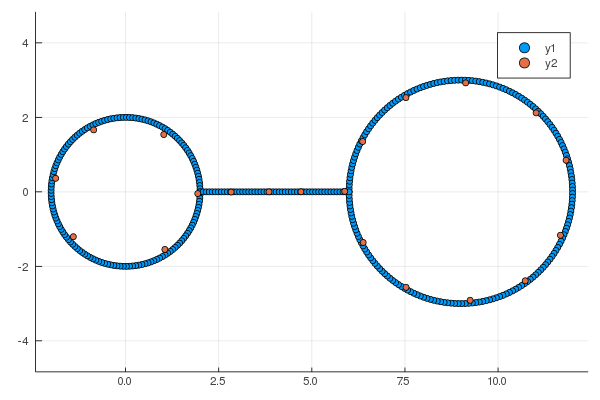

In [6]:
let
    data = permutedims(matread("mydata.mat")["X"]); # Transposed: Data in Julia are usually (n_dim, n_data)
    
    w, A = gng(data,
               20,   # max_neur
               20,   # max_iter
               50,  # λ
               50,   # max_life
               0.2,  # ϵ_bpu
               0.005, # ϵ_nei
               0.5,  # α
               0.995) # β

    scatter(data[1,:], data[2,:], aspect_ratio=:equal)
    scatter!(w[1,:], w[2,:], aspect_ratio=:equal)
end

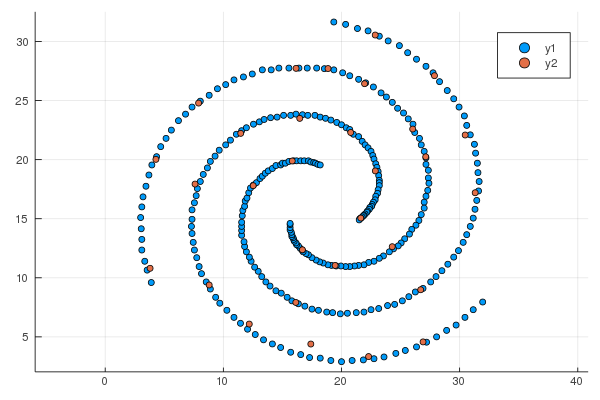

In [7]:
let
    data = permutedims(matread("spiral.mat")["X"]); # Transposed: Data in Julia are usually (n_dim, n_data)
    
    w, A = gng(data,
               30,   # max_neur
               50,   # max_iter
               100,  # λ
               10,   # max_life
               0.8,  # ϵ_bpu
               0.01, # ϵ_nei
               0.5,  # α
               0.995) # β

    scatter(data[1,:], data[2,:], aspect_ratio=:equal)
    scatter!(w[1,:], w[2,:], aspect_ratio=:equal)
end

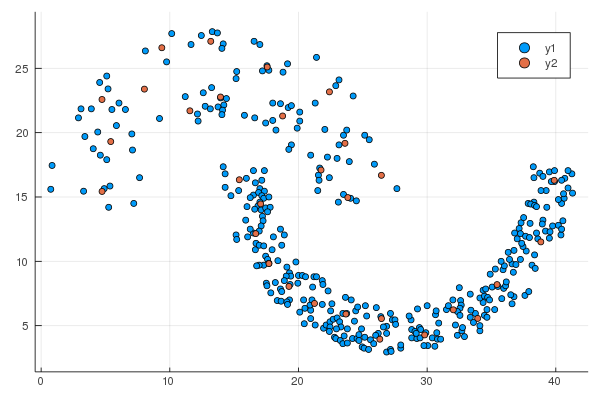

In [8]:
let
    data = permutedims(matread("jain.mat")["X"]); # Transposed: Data in Julia are usually (n_dim, n_data)
    
    w, A = gng(data,
               30,   # max_neur
               20,   # max_iter
               50,  # λ
               20,   # max_life
               0.2,  # ϵ_bpu
               0.005, # ϵ_nei
               0.5,  # α
               0.995) # β

    scatter(data[1,:], data[2,:], aspect_ratio=:equal)
    scatter!(w[1,:], w[2,:], aspect_ratio=:equal)
end

----------------------------